# MLE fit for three component binding - simulated data

In this notebook we will see how well we can reproduce Kd of a non-fluorescent ligand from simulated experimental data with a maximum likelihood function.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy import optimize
import seaborn as sns

%pylab inline

Populating the interactive namespace from numpy and matplotlib


:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [2]:
#Competitive binding function
def three_component_competitive_binding(Ptot, Ltot, Kd_L, Atot, Kd_A):
    """
    Parameters
    ----------
    Ptot : float
        Total protein concentration
    Ltot : float
        Total tracer(fluorescent) ligand concentration
    Kd_L : float
        Dissociation constant
    Atot : float
        Total competitive ligand concentration
    Kd_A : float
        Dissociation constant
        
    Returns
    -------
    P : float
        Free protein concentration
    L : float
        Free ligand concentration
    A : float
        Free ligand concentration
    PL : float
        Complex concentration
    Kd_L_app : float
        Apparent dissociation constant of L in the presence of A
        
    Usage
    -----
    [P, L, A, PL, Kd_L_app] = three_component_competitive_binding(Ptot, Ltot, Kd_L, Atot, Kd_A)
    """
    Kd_L_app = Kd_L*(1+Atot/Kd_A)                                
    PL = 0.5 * ((Ptot + Ltot + Kd_L_app) - np.sqrt((Ptot + Ltot + Kd_L_app)**2 - 4*Ptot*Ltot))  # complex concentration (uM)
    P = Ptot - PL; # free protein concentration in sample cell after n injections (uM)                                                                                                                                                                                                                          
    L = Ltot - PL; # free tracer ligand concentration in sample cell after n injections (uM)
    A = Atot - PL; # free competitive ligand concentration in sample cell after n injections (uM)
    return [P, L, A, PL, Kd_L_app]

In [3]:
#Let's define our parameters
Kd = 3800e-9 # M
Kd_Competitor = 3000e-9 # M
Ptot = 1e-9 * np.ones([12],np.float64) # M
Ltot = 20.0e-6 / np.array([10**(float(i)/2.0) for i in range(12)]) # M
L_Competitor =  10e-6 # M


In [4]:
[P, L, A, PL, Kd_L_app] = three_component_competitive_binding(Ptot, Ltot, Kd, L_Competitor, Kd_Competitor)
[P_base, L_base, A_base, PL_base, Kd_L_app_base] = three_component_competitive_binding(Ptot, Ltot, Kd, 0, Kd_Competitor)

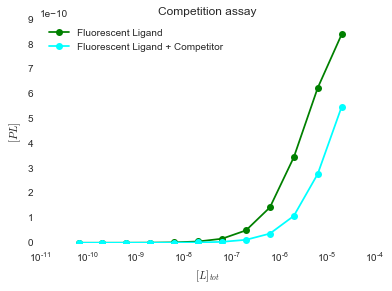

In [5]:
# y will be complex concentration
# x will be total ligand concentration
plt.title('Competition assay')
plt.semilogx(Ltot,PL_base,'green', marker='o', label = 'Fluorescent Ligand')
plt.semilogx(Ltot,PL,'cyan', marker='o', label = 'Fluorescent Ligand + Competitor')
plt.xlabel('$[L]_{tot}$')
plt.ylabel('$[PL]$')
plt.legend(loc=0);

In [6]:
#What if we change our Kd's a little
Kd_Gef_Abl = 480e-9 # M
Kd_Ima_Abl = 21.0e-9 # M

In [7]:
[P, L, A, PL, Kd_L_app] = three_component_competitive_binding(Ptot, Ltot, Kd_Gef_Abl, L_Competitor, Kd_Ima_Abl)
[P_base, L_base, A_base, PL_base, Kd_L_app_base] = three_component_competitive_binding(Ptot, Ltot, Kd_Gef_Abl, 0, Kd_Ima_Abl)

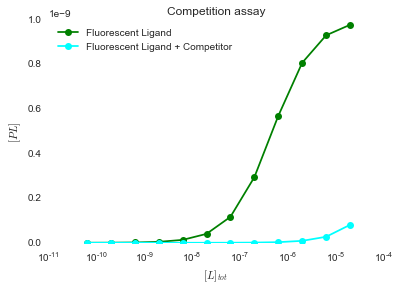

In [8]:
# y will be complex concentration
# x will be total ligand concentration
plt.title('Competition assay')
plt.semilogx(Ltot,PL_base,'green', marker='o', label = 'Fluorescent Ligand')
plt.semilogx(Ltot,PL,'cyan', marker='o', label = 'Fluorescent Ligand + Competitor')
plt.xlabel('$[L]_{tot}$')
plt.ylabel('$[PL]$')
plt.legend(loc=0);

## Now make this a fluorescence experiment.


In [9]:
# Making max 400 relative fluorescence units, and scaling all of PL to that
npoints = len(Ltot)
sigma = 10.0 # size of noise
F_i = (400/1e-9)*PL + sigma * np.random.randn(npoints)
F_i_base = (400/1e-9)*PL_base + sigma * np.random.randn(npoints)

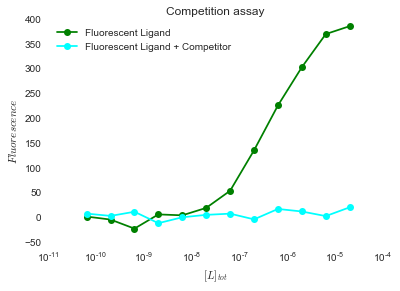

In [10]:
# y will be complex concentration
# x will be total ligand concentration
plt.title('Competition assay')
plt.semilogx(Ltot,F_i_base,'green', marker='o', label = 'Fluorescent Ligand')
plt.semilogx(Ltot,F_i,'cyan', marker='o', label = 'Fluorescent Ligand + Competitor')
plt.xlabel('$[L]_{tot}$')
plt.ylabel('$Fluorescence$')
plt.legend(loc=0);

In [11]:
#And makeup an F_L
F_L = 0.3

### First let's see if we can find Kd of our fluorescent ligand from the three component binding model, if we know there's no competitive ligand

In [15]:
def find_Kd_from_fluorescence(params):
    
    [F_background, F_PL, Kd] = params
    
    N = len(Ltot)
    Fmodel_i = np.zeros([N])
    
    for i in range(N):
        [P, L, A, PL, Kd_L_app] = three_component_competitive_binding(Ptot[0], Ltot[i], Kd_Gef_Abl, 0, Kd_Competitor)
        Fmodel_i[i] = (F_PL*PL + F_L*L) + F_background
    
    return Fmodel_i

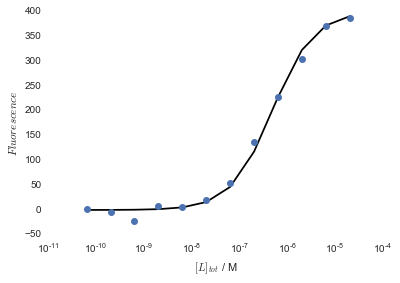

In [16]:
initial_guess = [0,400/1e-9,3800e-9]
prediction = find_Kd_from_fluorescence(initial_guess)

plt.semilogx(Ltot,prediction,color='k')
plt.semilogx(Ltot,F_i_base, 'o')
plt.xlabel('$[L]_{tot}$ / M')
plt.ylabel('$Fluorescence$')
plt.legend();

In [40]:
def sumofsquares(params):
    prediction = find_Kd_from_fluorescence(params)
    return np.sum((prediction - F_i_base)**2)

In [41]:
initial_guess = [0,3E11,20E-9]
fit = optimize.minimize(sumofsquares,initial_guess,method='Nelder-Mead')
print "The predicted parameters are", fit.x

The predicted parameters are [  1.14577907e+00   3.93974194e+11  -3.51125598e-06]


In [42]:
fit_prediction = find_Kd_from_fluorescence(fit.x)

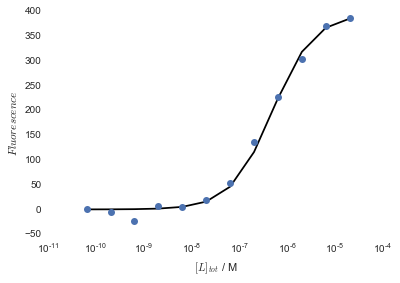

In [43]:
plt.semilogx(Ltot,fit_prediction,color='k')
plt.semilogx(Ltot,F_i_base, 'o')
plt.xlabel('$[L]_{tot}$ / M')
plt.ylabel('$Fluorescence$')
plt.legend();

In [44]:
Kd_Gef_Abl_MLE = fit.x[2]

In [45]:
def Kd_format(Kd):
    if (Kd < 1e-12):
        Kd_summary = "Kd = %.1f nM " % (Kd/1e-15)
    elif (Kd < 1e-9):
        Kd_summary = "Kd = %.1f pM " % (Kd/1e-12)
    elif (Kd < 1e-6):
        Kd_summary = "Kd = %.1f nM " % (Kd/1e-9)
    elif (Kd < 1e-3):
        Kd_summary = "Kd = %.1f uM " % (Kd/1e-66)
    elif (Kd < 1):
        Kd_summary = "Kd = %.1f mM " % (Kd/1e-3)
    else:
        Kd_summary = "Kd = %.3e M " % (Kd)
    
    return Kd_summary

In [46]:
Kd_format(Kd_Gef_Abl_MLE)

'Kd = -3511255978.6 nM '

In [47]:
delG_summary = "delG = %s kT" %np.log(Kd_Gef_Abl_MLE)

In [48]:
delG_summary

'delG = nan kT'